# TOBACCO - VGG - PSS Three Page

### Data Processing

As always, we'll import the modules we need. No new imports yet.

In [1]:
#Experiment Setup
DATA = 'tobacco800'
INPUT_DIM = 3
OUTPUT_DIM = 4
OUTPUT_METRIC = 2
NN = 'VGG16_200VAL'
PRE_PROCESS = 'SHUFFLEOFF'
POS_PROCESS = ''
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
FINETUNNING = ''
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
if PRE_PROCESS != '':
    EXPERIMENT += f'_PRE_{PRE_PROCESS}'
if POS_PROCESS != '':
    EXPERIMENT += f'_POS_{POS_PROCESS}'
if FINETUNNING != '':
    EXPERIMENT += f'_FT_{FINETUNNING}'
print(EXPERIMENT)

tobacco800_input_3_classes_4_nn_VGG16_200VAL_PRE_SHUFFLEOFF


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
    
from torch.optim.lr_scheduler import _LRScheduler
from torch import optim
import torch.utils.data as data

import timm
from timm.optim import optim_factory
from types import SimpleNamespace

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as tcmodels 

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
from PIL import Image

from skimage import io as skio, transform
import cv2
import math

import re

from utils import *

We'll also set the random seeds.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

In [4]:
class ThreePagesModule(nn.Module):
    def __init__(self, n_classes):
        super(ThreePagesModule, self).__init__()
        self.model = tcmodels.vgg16(pretrained=True)
        self.features = self.model.features

        for ch in self.features.children():
            layer_count = 0
            for layer in ch.children():
                print(layer)
                if layer_count<=23:
                    for param in layer.parameters():
                        param.requires_grad = False
                layer_count += 1            
            break
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512*7*7,512),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        
        self.final = nn.Sequential(
            nn.Linear(512*3, 256),
            nn.LeakyReLU(), 
            nn.Linear(256, n_classes),
            nn.LeakyReLU(),
            nn.Softmax(dim=1)
        )

    def forward(self, prev_page, targ_page, next_page):
        x1 = self.features(prev_page)
        x1 = self.classifier(x1)
        x2 = self.features(targ_page)
        x2 = self.classifier(x2)        
        x3 = self.features(next_page)
        x3 = self.classifier(x3)        
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.final(x)
        return x

In [5]:
OUTPUT_DIM = 4
model = ThreePagesModule(OUTPUT_DIM)

### Data Processing

In [6]:
pretrained_size = (224,224)
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

transform = transforms.Compose([
                            ResizeBinarize(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

In [7]:
PAGE_IMGS_PATH = '/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw/'
TRAIN_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/train.csv'
TEST_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/test.csv'

In [8]:
df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_test = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False) 

In [9]:
#aux_df = df_train.append(df_val, ignore_index=True)

In [10]:
'''
single_docs = len(aux_df[aux_df["pages"]==1])
total_docs = len(aux_df)
unicos = len(aux_df.radical.unique())
print(f'{single_docs} {total_docs-single_docs} {total_docs} {unicos} {unicos-single_docs} {(unicos-single_docs)/unicos}')

first_pages = len(aux_df[aux_df["page"]==1])
total_pages = len(aux_df)
print(f'{first_pages} {total_pages-first_pages} {total_pages} {first_pages/total_pages}')
'''

'\nsingle_docs = len(aux_df[aux_df["pages"]==1])\ntotal_docs = len(aux_df)\nunicos = len(aux_df.radical.unique())\nprint(f\'{single_docs} {total_docs-single_docs} {total_docs} {unicos} {unicos-single_docs} {(unicos-single_docs)/unicos}\')\n\nfirst_pages = len(aux_df[aux_df["page"]==1])\ntotal_pages = len(aux_df)\nprint(f\'{first_pages} {total_pages-first_pages} {total_pages} {first_pages/total_pages}\')\n'

In [11]:
def get_docid_radical_and_page(row):
    match = re.match(r"^([a-zA-Z0-9\-]*)(_(\d+))?$",row['docid'])
    if match:
        #print(match.groups()[0])
        row['radical'] = match.groups()[0]
        row['page'] = int(match.groups()[2]) if match.groups()[2] else 1
    else:
        print(error, row)
    return row

def get_extended_class(x):
    page = x['page'] 
    pages = x['pages']
    if pages == 1: 
        x['extended_class'] = 'single page'
        return x
    if page == 1:
        x['extended_class'] = 'first of many'
        return x
    if page == pages:
        x['extended_class'] = 'last page'
        return x
    x['extended_class'] = 'middle'
    return x

In [12]:
def add_extended_class_column(df):
    df = df.apply(get_docid_radical_and_page, axis=1)
    df_aux = df.groupby(['radical'], as_index=False)[['page']].max()
    df_aux.rename(columns={'page':'pages'}, inplace=True)
    df = df.merge(df_aux, how='left', on='radical')
    df = df.apply(get_extended_class, axis=1)
    return df.copy()

In [13]:
df_train = add_extended_class_column(df_train)
df_train['split'] = 'train'
df_test = add_extended_class_column(df_test)
df_test['split'] = 'test'

In [14]:
df_val = df_train.iloc[-200:,:]
df_train = df_train.iloc[:-200,:]

In [15]:
len(df_train),len(df_val), len(df_test)

(831, 200, 259)

In [16]:
print(df_train['class'].value_counts())
print()
print(df_val['class'].value_counts())
print()
print(df_test['class'].value_counts())

FirstPage    495
NextPage     336
Name: class, dtype: int64

NextPage     109
FirstPage     91
Name: class, dtype: int64

FirstPage    150
NextPage     109
Name: class, dtype: int64


In [17]:
stats_df = pd.concat([df_train, df_val], ignore_index=True)

In [18]:
stats_df.groupby('extended_class')['docid'].count()

extended_class
first of many    199
last page        199
middle           242
single page      391
Name: docid, dtype: int64

In [19]:
nd = stats_df[((stats_df['extended_class']=='first of many') | 
          (stats_df['extended_class']=='single page'))].shape# & 
         #(stats_df['class']!='FirstPage') & (stats_df['split'] == 'valid')].shape
print(nd[0]/stats_df.shape[0])
print(nd)

0.5722599418040737
(590, 9)


In [20]:
sd = stats_df[((stats_df['extended_class']=='last page') | 
          (stats_df['extended_class']=='middle'))].shape# & 
         #(stats_df['class']!='NextPage') & (stats_df['split'] == 'train')].shape 
print(sd[0]/stats_df.shape[0])
print(sd)

0.4277400581959263
(441, 9)


In [21]:
stats_df[stats_df['pages']==1].shape

(391, 9)

In [22]:
stats_df.groupby('class')['docid'].count()

class
FirstPage    586
NextPage     445
Name: docid, dtype: int64

In [23]:
len(stats_df.radical.unique())

590

In [24]:
stats_df[stats_df['pages']==1].shape

(391, 9)

In [ ]:
# stats_df.groupby('class')['docid'].count()

In [167]:
stats_df = stats_df.drop_duplicates(subset=['radical'])

In [168]:
labels = [*range(1, 11)]; labels = [str(x) for x in labels] ; labels[-1] = '>10';print(labels)
bins = [*range(0, 10)]; bins.append(float('inf')); print(bins)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '>10']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, inf]


In [169]:
stats_df['pages_cat'] = pd.cut(stats_df.pages, bins=bins,labels=labels )

In [170]:
stats_df.groupby('pages_cat')['radical'].count()

pages_cat
1      496
2      171
3       32
4       12
5        9
6        4
7        4
8        2
9        3
>10      9
Name: radical, dtype: int64

In [192]:
stats_df.groupby('extended_class')['radical'].count()

extended_class
first of many    237
last page          3
middle             6
single page      496
Name: radical, dtype: int64

In [254]:
stats_df['extended_class'].mode()

0    single page
dtype: object

In [172]:
496+171+32+12+9+4+4+2+3+9

742

In [173]:
465 + 179 +39 +15 +10 + 4 + 6 + 2 + 11 + 5

736

In [190]:
len(stats_df[stats_df['pages']==38])

1

In [184]:
stats_df.pages.unique()

array([ 2,  1,  3,  5,  8, 10,  4, 36,  6, 17,  9,  7, 15, 14, 38])

In [171]:
stats_df.shape

(742, 9)

In [25]:
del stats_df

In [26]:
label2Idx = {'single page': 3,'first of many': 2,'middle': 1,'last page':0}

In [27]:
class ThreePagesTobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, label2Idx, transform=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transform = transform
        self.label2Idx = label2Idx

    def __len__(self):
        return len(self.dataframe)
    
    def get_page_file_name_label(self, index, transform, target):
        if index < 0 or index >= len(self.dataframe):
            page = np.full_like(target, 255)
            file_name = None
            label = None
        else:     
            row = self.dataframe.iloc[index]
            file_name = row["docid"]+'.tif'
            page = skio.imread(self.root_dir+file_name,plugin='pil')
            label = row['extended_class']
        if transform:
            page = transform(page)
        return page, file_name, label

    def __getitem__(self, index):
        if type(index) != int:
            i = index.item()
        else: i = index
            
        row = self.dataframe.iloc[index]
        file_name = row["docid"]+'.tif'
        target_page = skio.imread(self.root_dir+file_name,plugin='pil')
        label = row['extended_class']        
        
        if index < 1:
            next_row = self.dataframe.iloc[index+1]
            prev_page = np.full_like(target_page, 255)
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')
        elif index >= len(self.dataframe) - 1:
            prev_row = self.dataframe.iloc[index-1]
            next_page = np.full_like(target_page, 255)
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
        else:
            prev_row = self.dataframe.iloc[index-1]
            next_row = self.dataframe.iloc[index+1]
            prev_name = prev_row["docid"]+'.tif'
            prev_page = skio.imread(self.root_dir+prev_name,plugin='pil')
            next_name = next_row["docid"]+'.tif'
            next_page = skio.imread(self.root_dir+next_name,plugin='pil')            
                    
        if self.transform:
            target_page = self.transform(target_page)
            prev_page = self.transform(prev_page)
            next_page = self.transform(next_page)
            
        return (
            [prev_page, target_page, next_page],
            self.label2Idx[label],
            file_name
        )

In [28]:
train_data = ThreePagesTobaccoDataset(df_train,PAGE_IMGS_PATH, label2Idx, transform )

valid_data = ThreePagesTobaccoDataset(df_val,PAGE_IMGS_PATH, label2Idx, transform )

test_data = ThreePagesTobaccoDataset(df_test,PAGE_IMGS_PATH, label2Idx, transform )

We'll print out the number of examples in each split to ensure they are correct

In [29]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 831
Number of validation examples: 200
Number of test examples: 259


We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [30]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    hc,wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa+wb+wc
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    new_img[:hc,wa+wb:wa+wb+wc]=imgc
    return new_img 
    

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(labels)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        
        prev_page = images[i][0]
        curr_page = images[i][1]
        next_page = images[i][2]

        ax = fig.add_subplot(rows, cols, i+1)
        
        if normalize:
            prev_page = normalize_image(prev_page)
            curr_page = normalize_image(curr_page)
            next_page = normalize_image(next_page)

        prev_page = prev_page.permute(1, 2, 0).cpu().numpy()    
        curr_page = curr_page.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()

        ax.imshow(concat_images(prev_page, curr_page, next_page))
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

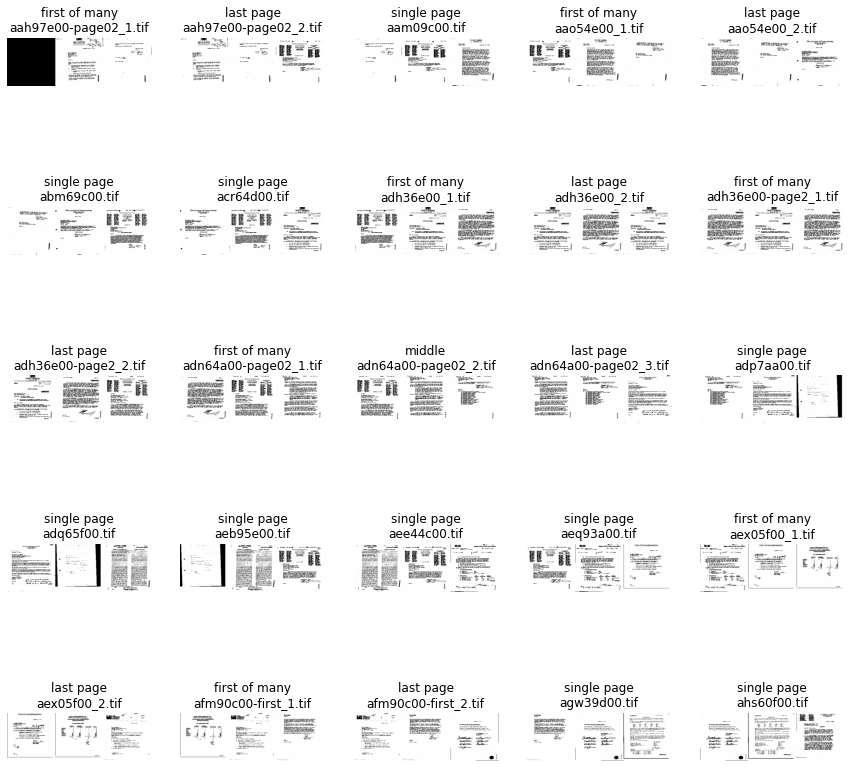

In [31]:
N_IMAGES = 25

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {3: 'single page',2: 'first of many',1:'middle',0:'last page'}

#prev_images, curr_images = images[0]

plot_images(images, labels, classes, file_names)

In [32]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE, shuffle=False)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [33]:
args = SimpleNamespace()
args.weight_decay = 0 
args.lr = 0.00005
args.opt="Nadam"

optimizer = optim_factory.create_optimizer(args,model)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

We create a function to calculate accuracy...

In [34]:
def calculate_accuracy(y_pred, y): 
    correct = y_pred.eq(y.view_as(y_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [35]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x1, x2, x3 = x
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x1, x2, x3)
        
        loss = criterion(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        acc = calculate_accuracy(top_pred, y)
        acc_2 = calculate_accuracy(top_pred//2, y//2)

        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        kappa_2 = cohen_kappa_score((y//2).tolist(), top_pred.flatten().cpu()//2)

        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_acc_2 += acc_2.item()
        epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 / len(iterator) 

...create a function that performs an evaluation loop...

In [36]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_2 = 0
    epoch_kappa = 0
    epoch_kappa_2 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, _) in iterator:
            
            x1, x2, x3 = x
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)            
            y = y.to(device)

            y_pred = model(x1, x2, x3)

            loss = criterion(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)

            acc = calculate_accuracy(top_pred, y)
            acc_2 = calculate_accuracy(top_pred//2, y//2)

            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
            kappa_2 = cohen_kappa_score((y//2).tolist(), top_pred.flatten().cpu()//2)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_acc_2 += acc_2.item()
            epoch_kappa += 1.0 if math.isnan(kappa) else kappa
            epoch_kappa_2 += 1.0 if math.isnan(kappa_2) else kappa_2
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator), epoch_acc_2 / len(iterator), epoch_kappa_2 / len(iterator) 

...and a helper function to tell us how long an epoch takes.

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
EPOCHS = 20

best_valid_loss = float('inf')

experiment_data = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa, train_acc_2, train_kappa_2 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa, valid_acc_2, valid_kappa_2 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print (f'Winner Epoch: {epoch+1:02}.')
        torch.save(model.state_dict(), './model/'+ EXPERIMENT+ '.pt')
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}% | Train Acc 2: {train_acc_2*100:.2f}% | Train Kappa 2: {train_kappa_2*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}% |  Val. Acc 2: {valid_acc_2*100:.2f}% |  Val. Kappa 2: {valid_kappa_2*100:.2f}%')

    experiment_data.append([train_loss, valid_loss, train_acc, valid_acc, train_kappa, valid_kappa, train_acc_2, valid_acc_2, train_kappa_2, valid_kappa_2, start_time, end_time])
    experiment_df = pd.DataFrame(experiment_data,columns=['train_loss','valid_loss','train_acc', 'valid_acc','train_kappa', 'valid_kappa', 'train_acc_2', 'valid_acc_2', 'train_kappa_2', 'valid_kappa_2', 'start', 'end' ])
    experiment_df.to_pickle('./model/'+ EXPERIMENT+ '.pk')

Winner Epoch: 01.
Epoch: 01 | Epoch Time: 2m 25s
	Train Loss: 1.308 | Train Acc: 40.47% | Train Kappa: 4.73% | Train Acc 2: 61.15% | Train Kappa 2: 5.26%
	 Val. Loss: 1.367 |  Val. Acc: 32.59% |  Val. Kappa: 9.32% |  Val. Acc 2: 47.32% |  Val. Kappa 2: 3.52%
Epoch: 02 | Epoch Time: 2m 14s
	Train Loss: 1.115 | Train Acc: 61.52% | Train Kappa: 40.25% | Train Acc 2: 78.23% | Train Kappa 2: 47.04%
	 Val. Loss: 1.238 |  Val. Acc: 48.66% |  Val. Kappa: 33.13% |  Val. Acc 2: 65.18% |  Val. Kappa 2: 31.15%
Winner Epoch: 03.
Epoch: 03 | Epoch Time: 2m 15s
	Train Loss: 0.967 | Train Acc: 77.62% | Train Kappa: 66.24% | Train Acc 2: 86.88% | Train Kappa 2: 69.17%
	 Val. Loss: 1.095 |  Val. Acc: 63.84% |  Val. Kappa: 51.20% |  Val. Acc 2: 83.04% |  Val. Kappa 2: 63.36%
Winner Epoch: 04.
Epoch: 04 | Epoch Time: 2m 15s
	Train Loss: 0.899 | Train Acc: 84.49% | Train Kappa: 74.53% | Train Acc 2: 91.47% | Train Kappa 2: 77.50%
	 Val. Loss: 1.086 |  Val. Acc: 65.62% |  Val. Kappa: 55.29% |  Val. Acc 2: 7

## W/O Shuffle
```shell 
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 2m 15s
	Train Loss: 1.310 | Train Acc: 41.54% | Train Kappa: 5.35% | Train Acc 2: 64.41% | Train Kappa 2: 11.54%
	 Val. Loss: 1.331 |  Val. Acc: 34.38% |  Val. Kappa: 13.55% |  Val. Acc 2: 68.75% |  Val. Kappa 2: 35.42%
Winner Epoch: 02.
Epoch: 02 | Epoch Time: 2m 15s
	Train Loss: 1.123 | Train Acc: 61.03% | Train Kappa: 41.11% | Train Acc 2: 79.55% | Train Kappa 2: 53.65%
	 Val. Loss: 1.184 |  Val. Acc: 54.46% |  Val. Kappa: 40.90% |  Val. Acc 2: 75.00% |  Val. Kappa 2: 49.46%
Winner Epoch: 03.
Epoch: 03 | Epoch Time: 2m 15s
	Train Loss: 0.971 | Train Acc: 76.66% | Train Kappa: 63.18% | Train Acc 2: 86.17% | Train Kappa 2: 66.27%
	 Val. Loss: 1.090 |  Val. Acc: 66.96% |  Val. Kappa: 55.46% |  Val. Acc 2: 83.93% |  Val. Kappa 2: 63.88%
Epoch: 04 | Epoch Time: 1m 22s
	Train Loss: 0.888 | Train Acc: 85.21% | Train Kappa: 75.81% | Train Acc 2: 91.70% | Train Kappa 2: 78.58%
	 Val. Loss: 1.116 |  Val. Acc: 62.95% |  Val. Kappa: 51.24% |  Val. Acc 2: 80.80% |  Val. Kappa 2: 59.06%
Winner Epoch: 05.
Epoch: 05 | Epoch Time: 2m 15s
	Train Loss: 0.861 | Train Acc: 88.57% | Train Kappa: 80.74% | Train Acc 2: 93.75% | Train Kappa 2: 85.01%
	 Val. Loss: 1.090 |  Val. Acc: 64.29% |  Val. Kappa: 54.28% |  Val. Acc 2: 82.14% |  Val. Kappa 2: 62.29%
Winner Epoch: 06.
Epoch: 06 | Epoch Time: 2m 16s
	Train Loss: 0.848 | Train Acc: 89.90% | Train Kappa: 84.10% | Train Acc 2: 94.71% | Train Kappa 2: 85.15%
	 Val. Loss: 1.085 |  Val. Acc: 63.39% |  Val. Kappa: 52.60% |  Val. Acc 2: 81.70% |  Val. Kappa 2: 62.24%
Epoch: 07 | Epoch Time: 1m 21s
	Train Loss: 0.831 | Train Acc: 91.47% | Train Kappa: 84.97% | Train Acc 2: 94.59% | Train Kappa 2: 84.63%
	 Val. Loss: 1.093 |  Val. Acc: 65.18% |  Val. Kappa: 54.35% |  Val. Acc 2: 81.25% |  Val. Kappa 2: 60.25%
Epoch: 08 | Epoch Time: 1m 20s
	Train Loss: 0.818 | Train Acc: 92.90% | Train Kappa: 87.96% | Train Acc 2: 95.55% | Train Kappa 2: 86.77%
	 Val. Loss: 1.092 |  Val. Acc: 64.29% |  Val. Kappa: 54.39% |  Val. Acc 2: 81.70% |  Val. Kappa 2: 62.36%
Epoch: 09 | Epoch Time: 1m 21s
	Train Loss: 0.804 | Train Acc: 94.10% | Train Kappa: 90.80% | Train Acc 2: 96.99% | Train Kappa 2: 92.09%
	 Val. Loss: 1.091 |  Val. Acc: 65.18% |  Val. Kappa: 55.34% |  Val. Acc 2: 83.04% |  Val. Kappa 2: 64.95%
Winner Epoch: 10.
Epoch: 10 | Epoch Time: 2m 14s
	Train Loss: 0.800 | Train Acc: 94.35% | Train Kappa: 90.50% | Train Acc 2: 96.51% | Train Kappa 2: 89.04%
	 Val. Loss: 1.079 |  Val. Acc: 65.18% |  Val. Kappa: 54.90% |  Val. Acc 2: 82.14% |  Val. Kappa 2: 63.15%
Epoch: 11 | Epoch Time: 1m 22s
	Train Loss: 0.794 | Train Acc: 95.19% | Train Kappa: 92.26% | Train Acc 2: 97.36% | Train Kappa 2: 92.93%
	 Val. Loss: 1.118 |  Val. Acc: 62.50% |  Val. Kappa: 52.17% |  Val. Acc 2: 79.46% |  Val. Kappa 2: 57.96%
Epoch: 12 | Epoch Time: 1m 21s
	Train Loss: 0.787 | Train Acc: 95.79% | Train Kappa: 93.20% | Train Acc 2: 97.60% | Train Kappa 2: 93.54%
	 Val. Loss: 1.095 |  Val. Acc: 64.73% |  Val. Kappa: 53.78% |  Val. Acc 2: 82.14% |  Val. Kappa 2: 61.76%
Winner Epoch: 13.
Epoch: 13 | Epoch Time: 2m 15s
	Train Loss: 0.789 | Train Acc: 95.55% | Train Kappa: 92.76% | Train Acc 2: 97.96% | Train Kappa 2: 94.29%
	 Val. Loss: 1.025 |  Val. Acc: 70.54% |  Val. Kappa: 59.14% |  Val. Acc 2: 84.82% |  Val. Kappa 2: 66.21%
Epoch: 14 | Epoch Time: 1m 22s
	Train Loss: 0.793 | Train Acc: 95.31% | Train Kappa: 91.58% | Train Acc 2: 97.24% | Train Kappa 2: 92.32%
	 Val. Loss: 1.086 |  Val. Acc: 65.18% |  Val. Kappa: 55.57% |  Val. Acc 2: 79.91% |  Val. Kappa 2: 58.83%
Epoch: 15 | Epoch Time: 1m 21s
	Train Loss: 0.787 | Train Acc: 95.55% | Train Kappa: 92.11% | Train Acc 2: 97.47% | Train Kappa 2: 90.99%
	 Val. Loss: 1.074 |  Val. Acc: 66.07% |  Val. Kappa: 55.91% |  Val. Acc 2: 83.48% |  Val. Kappa 2: 65.17%
Epoch: 16 | Epoch Time: 1m 21s
	Train Loss: 0.783 | Train Acc: 96.15% | Train Kappa: 93.03% | Train Acc 2: 98.08% | Train Kappa 2: 92.29%
	 Val. Loss: 1.058 |  Val. Acc: 68.30% |  Val. Kappa: 58.36% |  Val. Acc 2: 83.04% |  Val. Kappa 2: 65.17%
Epoch: 17 | Epoch Time: 1m 21s
	Train Loss: 0.783 | Train Acc: 96.03% | Train Kappa: 92.91% | Train Acc 2: 97.60% | Train Kappa 2: 91.25%
	 Val. Loss: 1.080 |  Val. Acc: 66.07% |  Val. Kappa: 56.78% |  Val. Acc 2: 81.70% |  Val. Kappa 2: 62.31%
Epoch: 18 | Epoch Time: 1m 21s
	Train Loss: 0.779 | Train Acc: 96.51% | Train Kappa: 93.57% | Train Acc 2: 97.96% | Train Kappa 2: 92.01%
	 Val. Loss: 1.069 |  Val. Acc: 66.96% |  Val. Kappa: 57.82% |  Val. Acc 2: 82.14% |  Val. Kappa 2: 63.24%
Epoch: 19 | Epoch Time: 1m 22s
	Train Loss: 0.781 | Train Acc: 96.39% | Train Kappa: 93.35% | Train Acc 2: 97.96% | Train Kappa 2: 92.09%
	 Val. Loss: 1.060 |  Val. Acc: 66.96% |  Val. Kappa: 57.69% |  Val. Acc 2: 82.59% |  Val. Kappa 2: 64.10%
Epoch: 20 | Epoch Time: 1m 21s
	Train Loss: 0.780 | Train Acc: 96.39% | Train Kappa: 93.38% | Train Acc 2: 98.08% | Train Kappa 2: 92.34%
	 Val. Loss: 1.052 |  Val. Acc: 69.64% |  Val. Kappa: 59.73% |  Val. Acc 2: 83.04% |  Val. Kappa 2: 63.09%
```

In [68]:
#print(EXPERIMENT)
#print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
#train_loss, valid_loss, train_acc,valid_acc,test_kappa,valid_kappa, train_acc_2, valid_acc_2, train_kappa_2, valid_kappa_2, start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

tobacco800_input_3_classes_4_nn_VGG16_200VAL
train_loss       7.887865e-01
valid_loss       1.025196e+00
train_acc        9.555288e-01
valid_acc        7.053571e-01
test_kappa       9.275606e-01
valid_kappa      5.913793e-01
train_acc_2      9.795673e-01
valid_acc_2      8.482143e-01
train_kappa_2    9.428899e-01
valid_kappa_2    6.620733e-01
start            1.284206e+06
end              1.284341e+06
Name: 12, dtype: float64


In [41]:
print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
train_loss, valid_loss, train_acc,valid_acc,test_kappa,valid_kappa,train_acc_2,valid_acc_2,train_kappa_2,valid_kappa_2,start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

train_loss       7.974720e-01
valid_loss       1.038198e+00
train_acc        9.459135e-01
valid_acc        6.696429e-01
train_kappa      9.145748e-01
valid_kappa      5.763331e-01
train_acc_2      9.687500e-01
valid_acc_2      8.125000e-01
train_kappa_2    9.205026e-01
valid_kappa_2    6.431391e-01
start            1.292048e+06
end              1.292182e+06
Name: 9, dtype: float64


In [42]:
model.load_state_dict(torch.load('./model/'+ EXPERIMENT+ '.pt'))

test_loss, test_acc, test_kappa, test_acc_2, test_kappa_2 = evaluate(model, test_iterator, criterion, device)

print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% |  Val. Kappa: {test_kappa*100:.2f}% |  Val. Acc 2: {test_acc_2*100:.2f}% |  Val. Kappa 2: {test_kappa_2*100:.2f}%')

	 Val. Loss: 0.898 |  Val. Acc: 85.07% |  Val. Kappa: 78.88% |  Val. Acc 2: 92.01% |  Val. Kappa 2: 83.42%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [43]:
def get_predictions(model, iterator):

    model.eval()

    prev_page_images = []
    curr_page_images = []
    next_page_images = []
    
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            prev_page, curr_page, next_page = x
            prev_page = prev_page.to(device)
            curr_page = curr_page.to(device)
            next_page = next_page.to(device)
            
            y_pred = model(prev_page, curr_page, next_page)
            
            #concat_images(prev_page.cpu(), curr_page.cpu(), next_page.cpu())

            prev_page_images.append(prev_page.cpu())
            curr_page_images.append(curr_page.cpu())
            next_page_images.append(next_page.cpu())
            labels.append(y.cpu()//2)
            probs.append(y_pred.cpu())
            file_names.append(name)

    prev_page_images = torch.cat(prev_page_images, dim = 0)
    curr_page_images = torch.cat(curr_page_images, dim = 0)
    next_page_images = torch.cat(next_page_images, dim = 0)    
    
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = list(sum(file_names, ()))

    return [prev_page_images, curr_page_images, next_page_images] , labels, probs, file_names

In [44]:
images, labels, probs, file_names = get_predictions(model, test_iterator)

...then get the predicted labels for each image...

In [46]:
pred_labels = torch.argmax(probs, 1)//2

...and then use these predictions to create a confusion matrix.

In [47]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.savefig('./model/'+ EXPERIMENT+ '_confusion_matrix.png')

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

In [48]:
classes = {'NextPage':0, 'FirstPage':1}

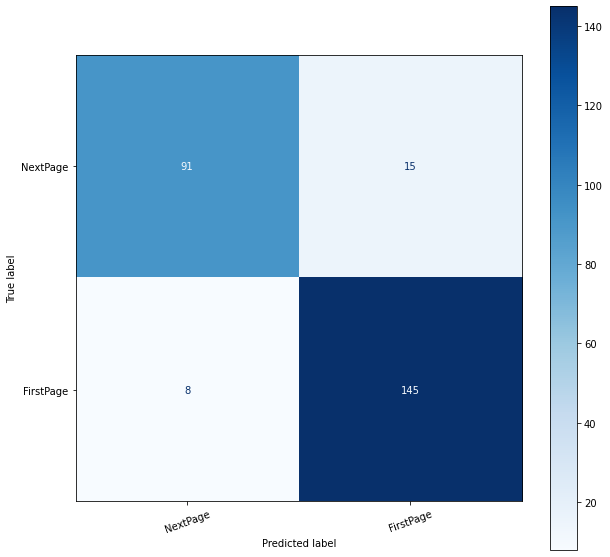

In [49]:
plot_confusion_matrix(labels, pred_labels, classes)

In [50]:
report_file_path = './report_final.json'
export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc_2, 
              valid_kappa_2,               
              test_loss, 
              test_acc_2, 
              test_kappa_2, 
              report_file_path) 

{'tobacco800_input_3_classes_4_nn_VGG16_200VAL_PRE_SHUFFLEOFF': {'NextPage': {'precision': 0.9191919191919192, 'recall': 0.8584905660377359, 'f1-score': 0.8878048780487805, 'support': 106}, 'FirstPage': {'precision': 0.90625, 'recall': 0.9477124183006536, 'f1-score': 0.926517571884984, 'support': 153}, 'accuracy': 0.9111969111969112, 'macro avg': {'precision': 0.9127209595959596, 'recall': 0.9031014921691947, 'f1-score': 0.9071612249668822, 'support': 259}, 'weighted avg': {'precision': 0.9115466927966928, 'recall': 0.9111969111969112, 'f1-score': 0.9106737666856111, 'support': 259}, 'valid_acc': 0.8125, 'valid_kappa': 0.6431391467649693, 'test_acc': 0.9201388888888888, 'test_kappa': 0.8341762169976494}}


We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [72]:
corrects = torch.eq(labels, pred_labels)

In [164]:
incorrect_examples = []

for prev_images, curr_images, next_images, label, prob, correct, file_name in zip(images[0], images[1], images[2], labels, probs, corrects, file_names):
    if not correct:
        incorrect_examples.append(([prev_images, curr_images, next_images], label, prob, file_name ))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [201]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images)) 
    cols = int(np.sqrt(n_images)) 

    fig = plt.figure(figsize = (30, 25))

    for i in range(rows*cols):  
    
        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs, file_name = incorrect[i]
        
        #probs = torch.argmax(probs, 1)//2
        
        prev_page = image[0]
        curr_page = image[1]
        next_page = image[2]        
        
        if normalize:
            prev_page = normalize_image(prev_page)
            curr_page = normalize_image(curr_page)
            next_page = normalize_image(next_page)

        prev_page = prev_page.permute(1, 2, 0).cpu().numpy()    
        curr_page = curr_page.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()
        
        image = concat_images(prev_page, curr_page, next_page)
        
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        incorrect_label = incorrect_label//2
        
        true_class = classes[true_label if type(true_label)==int else true_label.item()]
        incorrect_class = classes[incorrect_label if type(true_label)==int else incorrect_label.item()]

        ax.imshow(image)
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})\n {file_name}')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

11


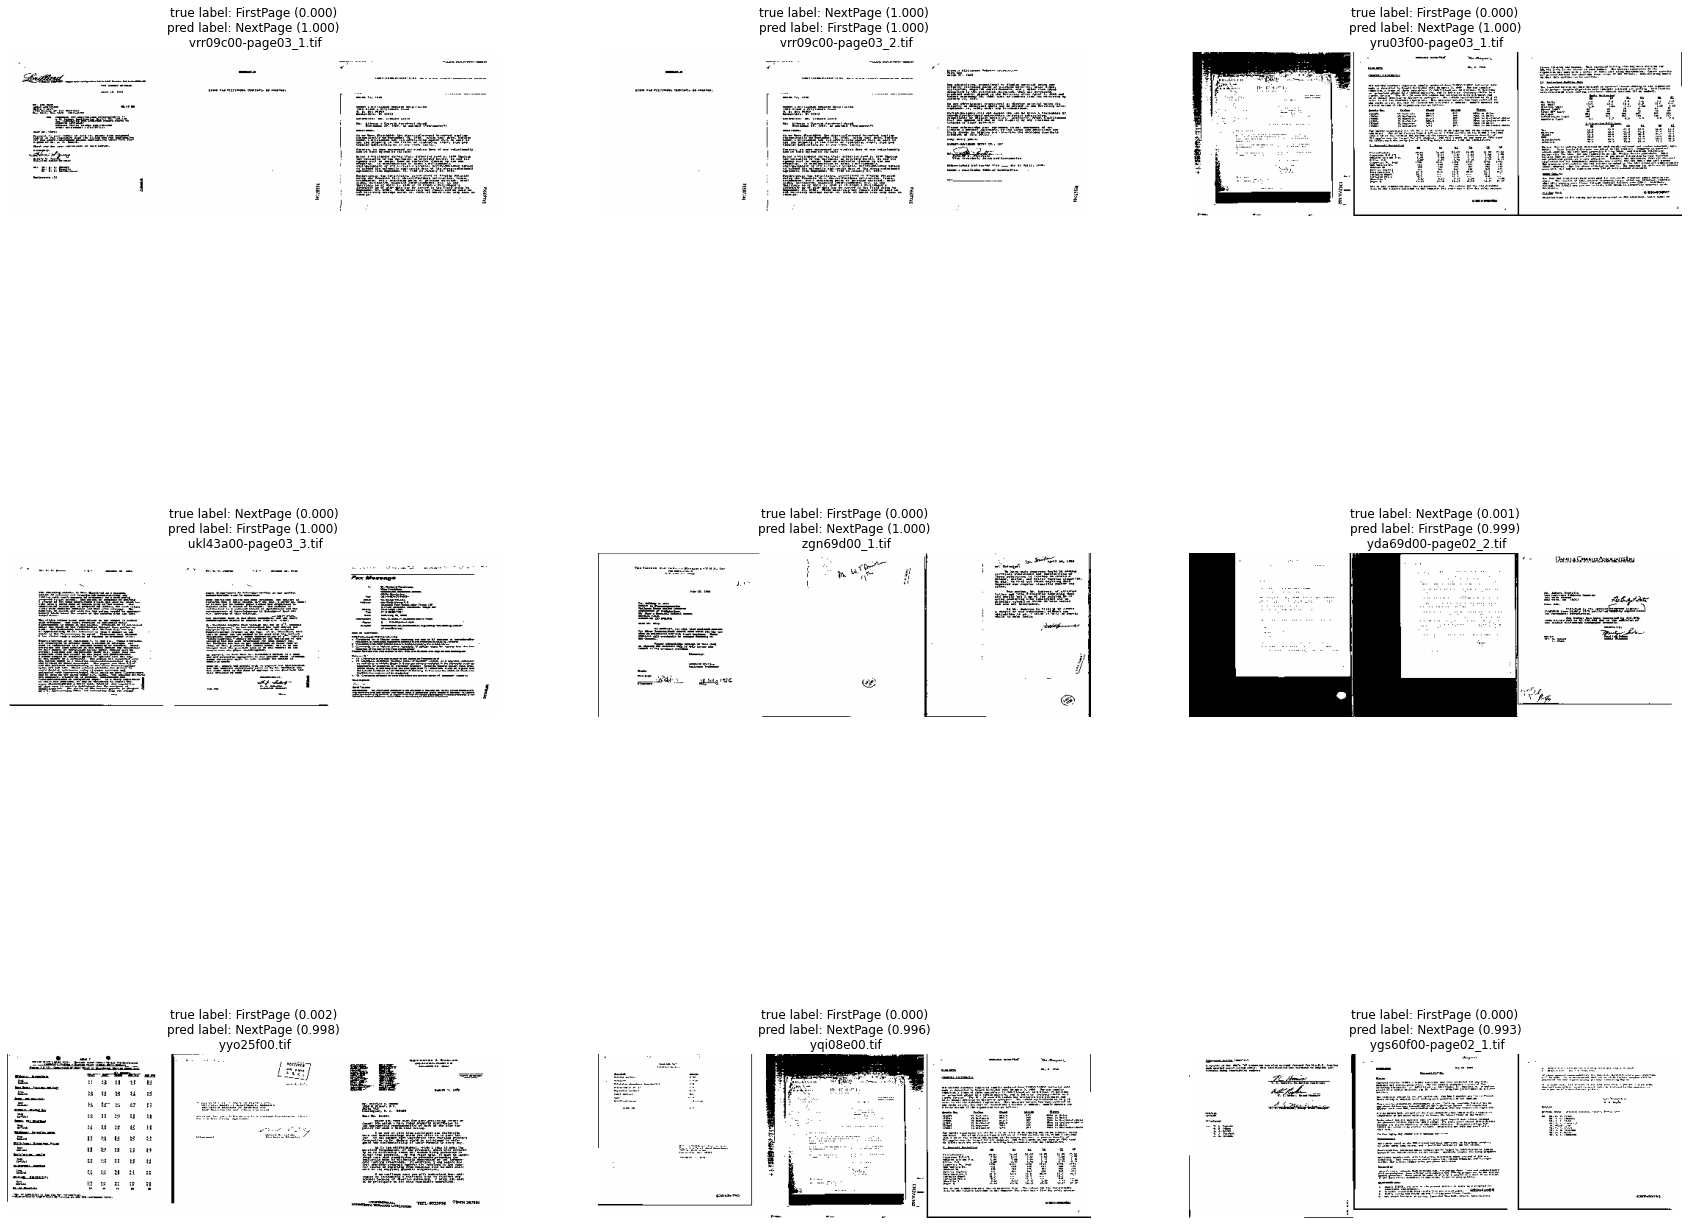

In [202]:
N_IMAGES = 36 if len(incorrect_examples) >= 36 else len(incorrect_examples)
print(N_IMAGES)
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are ten dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [212]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y, name) in iterator:

            prev_page, curr_page, next_page = x
            prev_page = prev_page.to(device)
            curr_page = curr_page.to(device)
            next_page = next_page.to(device)
            

            y_pred = model(prev_page, curr_page, next_page)
            
            aux = y_pred.cpu()

            outputs.append(y_pred.cpu())
            labels.append(y//2)
        
        outputs = torch.cat(outputs, dim = 0)
        labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [ ]:
outputs, labels = get_representations(model, valid_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [214]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [215]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

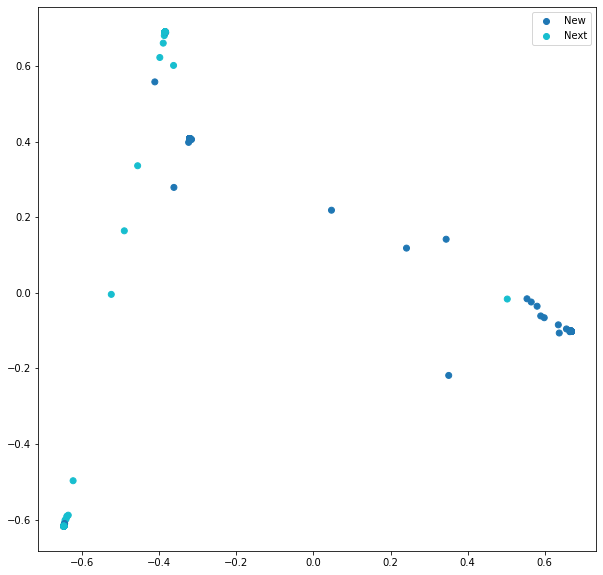

In [216]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, ['New','Next'])

Next up is calculating the t-SNE representations.

In [217]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

As mentioned in previous notebooks t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

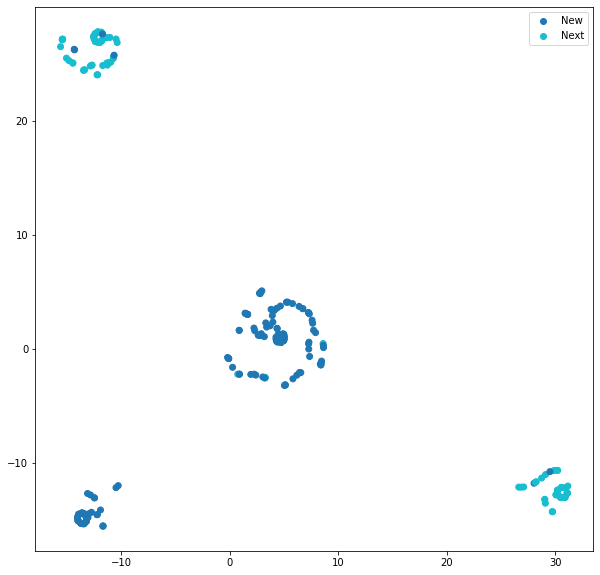

In [218]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, ['New','Next'], n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [225]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for il in images for i in il], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]
        
        prev_page = image[0]
        curr_page = image[1]
        next_page = image[2]

        if normalize:
            prev_page = normalize_image(prev_page)
            curr_page = normalize_image(curr_page)
            next_page = normalize_image(next_page)
        
        prev_page = prev_page.permute(1, 2, 0).cpu().numpy()    
        curr_page = curr_page.permute(1, 2, 0).cpu().numpy()
        next_page = next_page.permute(1, 2, 0).cpu().numpy()
        
        image = concat_images(prev_page, curr_page, next_page)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off'); 

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

In [226]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label, _ in [valid_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

RuntimeError: number of dims don't match in permute

<Figure size 2160x2160 with 0 Axes>

We can also plot out the actual filter weights learned by the model.

In [68]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

Even though these aren't as interpretable as the pre-trained AlexNet filters shown in the previous notebook, they are more interesting than the AlexNet filters learned from scratch. 

Interestingly there are multiple filters that are completely black, implying they all have filters weights that are basically zero.

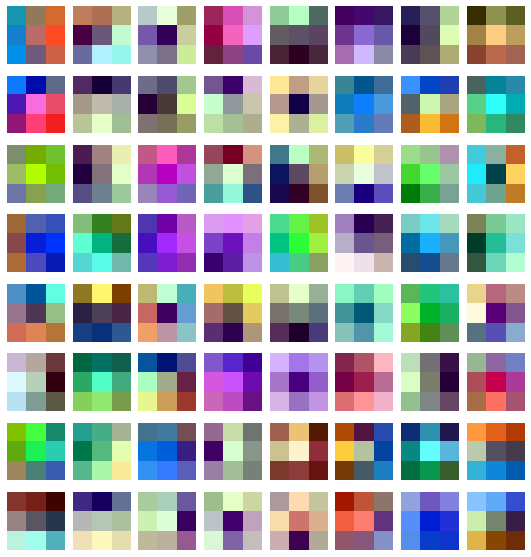

In [69]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (VGG)
- adaptive pooling
- batch normalization
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to freeze weights of our model
- how to use the learning rate finder
- how to use discriminative fine-tuning
- fine-tuning a pre-trained model to achieve >94% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model

In the next notebook we'll implement yet another popular CNN architecture, ResNet, and learn about how to pre-trained models ourselves using self-supervised learning.